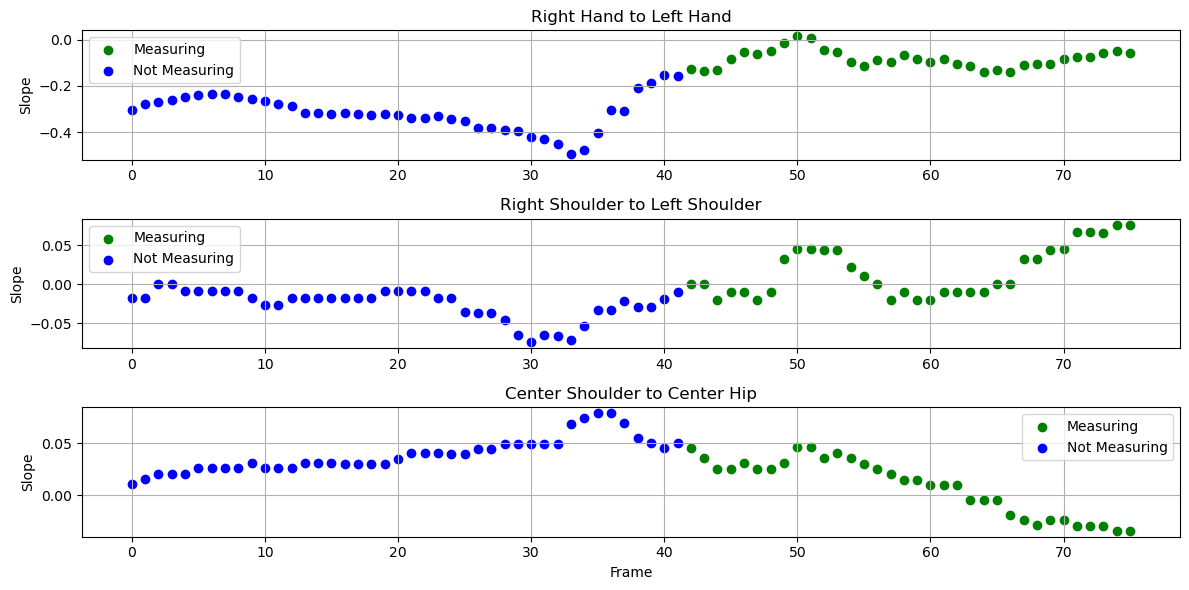

In [4]:
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
import os

# MediaPipeのセットアップ
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# 動画ファイルのパス
video_path ="C:\\Users\\natsu\\Downloads\\749448686.710547.mp4"
output_csv_path = os.path.splitext(video_path)[0] + "_slope.csv"

# 動画ファイルをキャプチャ
cap = cv2.VideoCapture(video_path)

frame_count = 0  # フレームカウンタ
start_frame = None  # スタートフレーム
stop_frame = None  # ストップフレーム

# データを保存するリスト
data = []

# 座標補正の変数
coordinate_correction = {
    'right_hand': 0,
    'left_hand': -17,
    'right_shoulder': 0,
    'left_shoulder': 0,
    'center_shoulder': 0,
    'center_hip': 0
}

# 許容範囲の傾き
tolerance = 0.02
length = 1

# MediaPipe Poseを初期化
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()  # 動画のフレームを取得
        
        if not ret:
            break  # フレームが取得できなかった場合はループを抜ける
        
        # BGR画像をRGBに変換
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False  # 画像を編集不可能に設定
        
        # MediaPipeでポーズ推定を実行
        results = pose.process(image)
        
        # RGB画像をBGRに戻す
        image.flags.writeable = True  # 画像を編集可能に設定
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # ポーズランドマークを取得
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            
            # 関心のあるランドマークのインデックス
            landmark_indices = {
                'right_hand': 16,      # 右手のランドマークインデックス
                'left_hand': 15,       # 左手のランドマークインデックス
                'right_elbow': 14,     # 右ひじのランドマークインデックス
                'left_elbow': 13,      # 左ひじのランドマークインデックス
                'right_shoulder': 12,  # 右肩のランドマークインデックス
                'left_shoulder': 11,   # 左肩のランドマークインデックス
                'left_hip': 23,        # 左腰のランドマークインデックス
                'right_hip': 24        # 右腰のランドマークインデックス
            }
            
            points = {}
            for name, index in landmark_indices.items():
                point = landmarks[index]
                # 画像上の座標に変換して保存
                y_offset = coordinate_correction.get(name, 0)
                points[name] = (int(point.x * image.shape[1]), int(point.y * image.shape[0]) + round(y_offset*1/1))

            # 中点計算
            left_shoulder = points['left_shoulder']
            right_shoulder = points['right_shoulder']
            center_shoulder = (
                (left_shoulder[0] + right_shoulder[0]) // 2,
                (left_shoulder[1] + right_shoulder[1]) // 2 + coordinate_correction['center_shoulder']
            )
            points['center_shoulder'] = center_shoulder
            
            left_hip = points['left_hip']
            right_hip = points['right_hip']
            center_hip = (
                (left_hip[0] + right_hip[0]) // 2,
                (left_hip[1] + right_hip[1]) // 2 + coordinate_correction['center_hip']
            )
            points['center_hip'] = center_hip

            # スタート条件: 両手が肩より上にある
            if points['right_hand'][1] < points['right_shoulder'][1] and points['left_hand'][1] < points['left_shoulder'][1]:
                start_frame = frame_count
            
            # ストップ条件: 右手が右肘より左にある
            if start_frame is not None and points['right_hand'][0] < points['right_elbow'][0]:
                stop_frame = frame_count

            # 計測中の表示
            is_measuring = 0
            if start_frame is not None and stop_frame is None:
                is_measuring = 1
                cv2.putText(image, f'measuring', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            cv2.putText(image, f'Frame: {frame_count}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

            # ランドマークを線で結ぶ
            green_lines = [
                ('right_hand', 'left_hand'),        # 右手と左手を結ぶ線
                ('right_shoulder', 'left_shoulder'), # 右肩と左肩を結ぶ線
                ('center_shoulder', 'center_hip')   # 肩の中点と腰の中点を結ぶ線
            ]
            
            frame_data = {
                'frame': frame_count,
                'is_measuring': is_measuring
            }
            
            for start, end in green_lines:
                if start in points and end in points:
                    # 傾きを計算
                    dx = points[end][0] - points[start][0]
                    dy = points[end][1] - points[start][1]
                    if start == "right_hand":
                        length = dx
                    if dx == 0:  # 完全に垂直な場合
                        slope = float('inf')  # 無限大として扱う
                    else:
                        slope = dy / dx
                    if start == 'center_shoulder' and end == 'center_hip':
                        if dx == 0:
                            slope = 0
                        else:
                            slope = 1/slope
                    frame_data[start + '_' + end] = slope
                    
                    # 線を描画
                    if abs(slope) < tolerance:
                        line_color = (0, 255, 0)  # 緑色
                    else:
                        line_color = (255, 0, 0)  # 青色
                    cv2.line(image, points[start], points[end], line_color, 2)

            data.append(frame_data)

        # フレームのリサイズ（幅640ピクセルにリサイズ、縦横比を維持）
        scale_percent = 640 / image.shape[1]
        width = int(image.shape[1] * scale_percent)
        height = int(image.shape[0] * scale_percent)
        resized_frame = cv2.resize(image, (width, height))
        
        # フレームを表示
        cv2.imshow('Frame', resized_frame)
        
        # 'q'キーが押されたら終了
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # フレームカウントを増やす
        frame_count += 1

# キャプチャを解放してウィンドウを閉じる
cap.release()
cv2.destroyAllWindows()

# データをPandas DataFrameに変換
df = pd.DataFrame(data)

# 傾きデータをCSVファイルに保存
df.to_csv(output_csv_path, index=False)

# 計測中の部分のみ抽出
df_measuring = df[df['is_measuring'] == 1]
df_not_measuring = df[df['is_measuring'] == 0]

# グラフを作成
plt.figure(figsize=(12, 6))

# Right Hand to Left Handの傾きグラフ
plt.subplot(3, 1, 1)
plt.scatter(df_measuring['frame'], df_measuring['right_hand_left_hand'], color='green', label='Measuring')
plt.scatter(df_not_measuring['frame'], df_not_measuring['right_hand_left_hand'], color='blue', label='Not Measuring')
plt.ylabel('Slope')
plt.title('Right Hand to Left Hand')
plt.legend()
plt.grid(True)

# Right Shoulder to Left Shoulderの傾きグラフ
plt.subplot(3, 1, 2)
plt.scatter(df_measuring['frame'], df_measuring['right_shoulder_left_shoulder'], color='green', label='Measuring')
plt.scatter(df_not_measuring['frame'], df_not_measuring['right_shoulder_left_shoulder'], color='blue', label='Not Measuring')
plt.ylabel('Slope')
plt.title('Right Shoulder to Left Shoulder')
plt.legend()
plt.grid(True)

# Center Shoulder to Center Hipの傾きグラフ
plt.subplot(3, 1, 3)
plt.scatter(df_measuring['frame'], df_measuring['center_shoulder_center_hip'], color='green', label='Measuring')
plt.scatter(df_not_measuring['frame'], df_not_measuring['center_shoulder_center_hip'], color='blue', label='Not Measuring')
plt.xlabel('Frame')
plt.ylabel('Slope')
plt.title('Center Shoulder to Center Hip')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


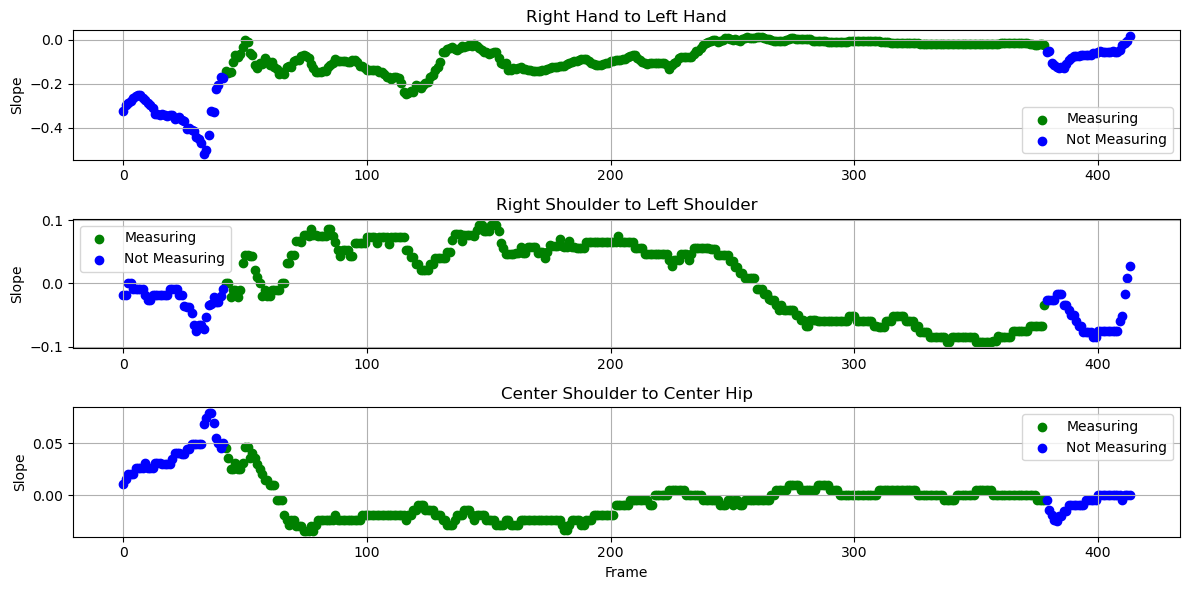

In [14]:
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
import os

# MediaPipeのセットアップ
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# 動画ファイルのパス
video_path = "749448686.710547.mp4"
output_csv_path = os.path.splitext(video_path)[0] + "_slope.csv"

# 動画ファイルをキャプチャ
cap = cv2.VideoCapture(video_path)
# 保存する動画ファイルのパス
resized_output_video_path = "resized_output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# フレームの幅と高さを取得
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# リサイズされたフレーム用の VideoWriter オブジェクトを初期化
resized_frame_width = 640
resized_frame_height = int(frame_height * (640 / frame_width))
resized_out = cv2.VideoWriter(resized_output_video_path, fourcc, 30.0, (resized_frame_width, resized_frame_height))



frame_count = 0  # フレームカウンタ
start_frame = None  # スタートフレーム
stop_frame = None  # ストップフレーム

# データを保存するリスト
data = []

# 座標補正の変数
coordinate_correction = {
    'right_hand': 0,
    'left_hand': -18.74,
    'right_shoulder': 0,
    'left_shoulder': 0,
    'center_shoulder': 0,
    'center_hip': 0
}

# 許容範囲の傾き
tolerance = 0.02
length = 1

# MediaPipe Poseを初期化
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()  # 動画のフレームを取得

        if not ret:
            break  # フレームが取得できなかった場合はループを抜ける

        # BGR画像をRGBに変換
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False  # 画像を編集不可能に設定

        # MediaPipeでポーズ推定を実行
        results = pose.process(image)

        # RGB画像をBGRに戻す
        image.flags.writeable = True  # 画像を編集可能に設定
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # ポーズランドマークを取得
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 関心のあるランドマークのインデックス
            landmark_indices = {
               'right_hand': 16, 
                'left_hand': 15,
                'right_elbow': 14,     # 右ひじのランドマークインデックス
                'left_elbow': 13,      # 左ひじのランドマークインデックス
                'right_shoulder': 12,  # 右肩のランドマークインデックス
                'left_shoulder': 11,   # 左肩のランドマークインデックス
                'left_hip': 23,        # 左腰のランドマークインデックス
                'right_hip': 24        # 右腰のランドマークインデックス
            }

            points = {}
            for name, index in landmark_indices.items():
                point = landmarks[index]
                # 画像上の座標に変換して保存
                y_offset = coordinate_correction.get(name, 0)
                points[name] = (int(point.x * image.shape[1]), int(point.y * image.shape[0]) + round(y_offset * 1 / 1))

            # 中点計算
            left_shoulder = points['left_shoulder']
            right_shoulder = points['right_shoulder']
            center_shoulder = (
                (left_shoulder[0] + right_shoulder[0]) // 2,
                (left_shoulder[1] + right_shoulder[1]) // 2 + coordinate_correction['center_shoulder']
            )
            points['center_shoulder'] = center_shoulder

            left_hip = points['left_hip']
            right_hip = points['right_hip']
            center_hip = (
                (left_hip[0] + right_hip[0]) // 2,
                (left_hip[1] + right_hip[1]) // 2 + coordinate_correction['center_hip']
            )
            points['center_hip'] = center_hip

            # スタート条件: 両手が肩より上にある
            if points['right_hand'][1] < points['right_shoulder'][1] and points['left_hand'][1] < points['left_shoulder'][1]:
                start_frame = frame_count

            # ストップ条件: 右手が右肘より左にある
            if start_frame is not None and points['right_hand'][0] < points['right_elbow'][0]:
                stop_frame = frame_count

            # 計測中の表示
            is_measuring = 0
            if start_frame is not None and stop_frame is None:
                is_measuring = 1
                cv2.putText(image, f'measuring', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            cv2.putText(image, f'Frame: {frame_count}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

            # ランドマークを線で結ぶ
            green_lines = [
                ('right_hand', 'left_hand'),        # 右手と左手を結ぶ線
                ('right_shoulder', 'left_shoulder'), # 右肩と左肩を結ぶ線
                ('center_shoulder', 'center_hip')   # 肩の中点と腰の中点を結ぶ線
            ]

            frame_data = {
                'frame': frame_count,
                'is_measuring': is_measuring
            }

            for start, end in green_lines:
                if start in points and end in points:
                    # 傾きを計算
                    dx = points[end][0] - points[start][0]
                    dy = points[end][1] - points[start][1]
                    if start == "right_hand":
                        length = dx
                    if dx == 0:  # 完全に垂直な場合
                        slope = float('inf')  # 無限大として扱う
                    else:
                        slope = dy / dx
                    if start == 'center_shoulder' and end == 'center_hip':
                        if dx == 0:
                            slope = 0
                        else:
                            slope = 1 / slope
                    frame_data[start + '_' + end] = slope

                    # 線を描画
                    if abs(slope) < tolerance:
                        line_color = (0, 255, 0)  # 緑色
                    else:
                        line_color = (255, 0, 0)  # 青色
                    cv2.line(image, points[start], points[end], line_color, 2)

                    # 傾きを表示
                    slope_text = f'Slope:{slope*45:.3f}°'
                    cv2.putText(image, slope_text,(points[end][0] + 10, points[end][1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            data.append(frame_data)
             # 赤色の線を引くペア
            red_lines = [
                 
                ('right_hand', 'right_elbow'),
                ('right_elbow', 'right_shoulder'),
                ('left_hand', 'left_elbow'),
                ('left_elbow', 'left_shoulder')
            ]
            
            for start, end in red_lines:
                if start in points and end in points:
                    # 各ランドマーク間に赤色の線を引く
                    cv2.line(image, points[start], points[end], (0, 0, 255), 2)

        # フレームのリサイズ（幅640ピクセルにリサイズ、縦横比を維持）
        scale_percent = 640 / image.shape[1]
        width = int(image.shape[1] * scale_percent)
        height = int(image.shape[0] * scale_percent)
        resized_frame = cv2.resize(image, (width, height))

        # フレームを表示
        cv2.imshow('Frame', resized_frame)

        # 'q'キーが押されたら終了
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # フレームカウントを増やす
        frame_count += 1
        # フレームを書き込む
       
        resized_out.write(resized_frame)

# キャプチャを解放してウィンドウを閉じる
cap.release()
resized_out.release()  # リサイズされた動画の保存を解放
cv2.destroyAllWindows()



# データをPandas DataFrameに変換
df = pd.DataFrame(data)

# 傾きデータをCSVファイルに保存
df.to_csv(output_csv_path, index=False)

# 計測中の部分のみ抽出
df_measuring = df[df['is_measuring'] == 1]
df_not_measuring = df[df['is_measuring'] == 0]

# グラフを作成
plt.figure(figsize=(12, 6))

# Right Hand to Left Handの傾きグラフ
plt.subplot(3, 1, 1)
plt.scatter(df_measuring['frame'], df_measuring['right_hand_left_hand'], color='green', label='Measuring')
plt.scatter(df_not_measuring['frame'], df_not_measuring['right_hand_left_hand'], color='blue', label='Not Measuring')
plt.ylabel('Slope')
plt.title('Right Hand to Left Hand')
plt.legend()
plt.grid(True)

# Right Shoulder to Left Shoulderの傾きグラフ
plt.subplot(3, 1, 2)
plt.scatter(df_measuring['frame'], df_measuring['right_shoulder_left_shoulder'], color='green', label='Measuring')
plt.scatter(df_not_measuring['frame'], df_not_measuring['right_shoulder_left_shoulder'], color='blue', label='Not Measuring')
plt.ylabel('Slope')
plt.title('Right Shoulder to Left Shoulder')
plt.legend()
plt.grid(True)

# Center Shoulder to Center Hipの傾きグラフ
plt.subplot(3, 1, 3)
plt.scatter(df_measuring['frame'], df_measuring['center_shoulder_center_hip'], color='green', label='Measuring')
plt.scatter(df_not_measuring['frame'], df_not_measuring['center_shoulder_center_hip'], color='blue', label='Not Measuring')
plt.xlabel('Frame')
plt.ylabel('Slope')
plt.title('Center Shoulder to Center Hip')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
